In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

import keras
from keras import layers, Model, models
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback
from keras import backend as K
from keras.utils import to_categorical
from keras.regularizers import l1, l2
from keras.optimizers import rmsprop, adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy.ndimage import shift
from skimage import transform
from skimage import util

## Data preparation

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print("Training set has shape {}".format(x_train.shape))
print("Testing set has shape {}".format(x_test.shape))

Training set has shape (50000, 32, 32, 3)
Testing set has shape (10000, 32, 32, 3)


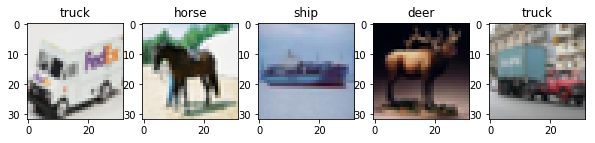

In [4]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
random_img = np.random.randint(0, len(x_train), 5)
fig, ax = plt.subplots(1, 5, figsize = (10,5))
for i, ind in enumerate(random_img):
    ax[i].imshow(x_train[ind])
    ax[i].set_title(classes[y_train[ind][0]])

In [5]:
classes_count = pd.value_counts(pd.Series(y_train.reshape(len(x_train)))).sort_index()
classes_count

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64

In [0]:
# scaling the data is important for the NN
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

In [0]:
# condition on data
# 50% of bird, deer and truck classes

p_classes = (1, 1, 0.5, 1, 0.5, 1, 1, 1, 1, 0.5)
x, y = [], []
for i, p in enumerate(p_classes):
    ids = np.random.choice(np.where(y_train==i)[0], int(p*classes_count[i]), replace=False)
    y.append(y_train[ids])
    x.append(x_train[ids])

In [8]:
x_ptrain = np.concatenate(x)
y_ptrain = np.concatenate(y)
x_ptrain.shape

(42500, 32, 32, 3)

In [0]:
# randomly shuffle the data
ids = np.random.permutation(len(x_ptrain))
x_ptrain = x_ptrain[ids]
y_ptrain = y_ptrain[ids]

In [0]:
# split the data to training set and validation set
num_classes = 10
y_tr_cat = keras.utils.to_categorical(y_ptrain, num_classes=num_classes)
x_tr, x_val, y_tr, y_val = train_test_split(x_ptrain, y_tr_cat,test_size = 0.2, random_state=123, stratify=y_ptrain)

In [11]:
x_tr.shape, x_val.shape, y_tr.shape

((34000, 32, 32, 3), (8500, 32, 32, 3), (34000, 10))

## Train Auto-Encoder separately

#### 1- simple autoencoder

In [12]:
batch_size = 64
epochs = 100
inputs = layers.Input(shape=(32, 32, 3))

In [0]:
# create the autoencoder
# we will start with a simple model

#encoder
def encoder_1(inputs):
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(4, 3, activation="relu", padding="same")(x)
    return x

#decoder
def decoder_1(encoded):
    x = layers.Conv2D(4, 3, activation="relu", padding="same")(encoded)
    x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
    return decoded

autoencoder_1 = Model(inputs, decoder_1(encoder_1(inputs)))

W0904 09:41:59.368316 140595764918144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 09:41:59.402646 140595764918144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0904 09:41:59.486419 140595764918144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2239: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



In [0]:
autoencoder_1.compile(optimizer="adam", loss="mse")
autoencoder_1.summary()

W0904 09:41:59.548852 140595764918144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0   

In [0]:
autoencoder_history = autoencoder_1.fit(x_tr, x_tr, batch_size=batch_size, epochs=50, validation_data=(x_val, x_val))

W0904 09:41:59.793561 140595764918144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0904 09:42:00.129217 140595764918144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 34000 samples, validate on 8500 samples
Epoch 1/50
34000/34000 [==============================] - 15s 446us/step - loss: 0.0290 - val_loss: 0.0228
Epoch 2/50
34000/34000 [==============================] - 9s 269us/step - loss: 0.0210 - val_loss: 0.0194
Epoch 3/50
34000/34000 [==============================] - 9s 270us/step - loss: 0.0189 - val_loss: 0.0187
Epoch 4/50
34000/34000 [==============================] - 9s 273us/step - loss: 0.0179 - val_loss: 0.0176
Epoch 5/50
34000/34000 [==============================] - 9s 269us/step - loss: 0.0170 - val_loss: 0.0165
Epoch 6/50
34000/34000 [==============================] - 9s 267us/step - loss: 0.0164 - val_loss: 0.0162
Epoch 7/50
34000/34000 [==============================] - 9s 268us/step - loss: 0.0160 - val_loss: 0.0161
Epoch 8/50
34000/34000 [==============================] - 9s 268us/step - loss: 0.0157 - val_loss: 0.0156
Epoch 9/50
34000/34000 [==============================] - 9s 267us/step - loss: 0.0155 - val_loss: 0.0

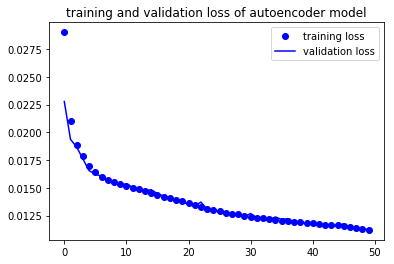

In [0]:
train_loss = autoencoder_history.history["loss"]
val_loss = autoencoder_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

even though the model result can improve with more training, the result are not satisfying. Next we will add more complexity to the model

#### 2- add complexity 

In [0]:
#encoder
def encoder_2(inputs):
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    encoded = layers.BatchNormalization(name="encoder")(x)
    return encoded

#decoder
def decoder_2(encoded):
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
    return decoded

autoencoder_2 = Model(inputs, decoder_2(encoder_2(inputs)))

W0904 09:49:30.561621 140595764918144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



In [0]:
autoencoder_2.compile(optimizer="adam", loss="mse")

In [0]:
autoencoder_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        1849

In [0]:
autoencoder_history = autoencoder_2.fit(x_tr, x_tr, batch_size=batch_size, epochs=50, validation_data=(x_val, x_val))

Train on 34000 samples, validate on 8500 samples
Epoch 1/50
34000/34000 [==============================] - 58s 2ms/step - loss: 0.0182 - val_loss: 0.0245
Epoch 2/50
34000/34000 [==============================] - 51s 2ms/step - loss: 0.0113 - val_loss: 0.0136
Epoch 3/50
34000/34000 [==============================] - 50s 1ms/step - loss: 0.0095 - val_loss: 0.0119
Epoch 4/50
34000/34000 [==============================] - 49s 1ms/step - loss: 0.0083 - val_loss: 0.0092
Epoch 5/50
34000/34000 [==============================] - 49s 1ms/step - loss: 0.0073 - val_loss: 0.0097
Epoch 6/50
34000/34000 [==============================] - 49s 1ms/step - loss: 0.0066 - val_loss: 0.0100
Epoch 7/50
34000/34000 [==============================] - 49s 1ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 8/50
34000/34000 [==============================] - 49s 1ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 9/50
34000/34000 [==============================] - 49s 1ms/step - loss: 0.0053 - val_loss: 0.0062
Epoch 

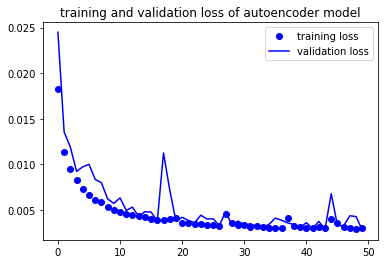

In [0]:
train_loss = autoencoder_history.history["loss"]
val_loss = autoencoder_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

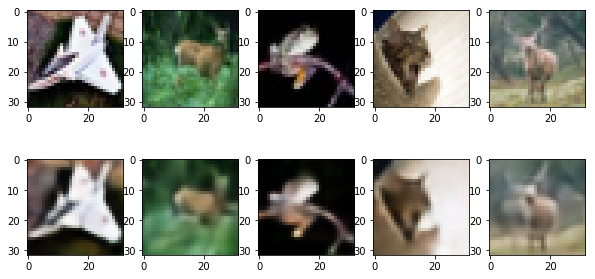

In [0]:
random_img = np.random.randint(0, len(x_val), 5)
fig, ax = plt.subplots(2, 5, figsize = (10,5))
for i, ind in enumerate(random_img):
    ax[0,i].imshow(x_val[ind])
    ax[1,i].imshow(autoencoder_2.predict(np.expand_dims(x_val[ind], 0)).reshape(32, 32, 3))

In [0]:
# save model weights
autoencoder_2.save_weights('autoencoder_2_weights.h5')

In [0]:
# create the classifier
def cnn_model(encoded):
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dense(num_classes, activation="softmax")(x)
    return x
encoded = encoder_2(inputs)
classifier_1 = Model(inputs, cnn_model(encoded))
classifier_1.summary()

W0904 10:30:37.269347 140595764918144 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)        1849

In [0]:
# copy weights from the autoencoder
for clf_w, autoenc_w in zip(classifier_1.layers[:20], autoencoder_2.layers[:20]):
    clf_w.set_weights(autoenc_w.get_weights())

In [0]:
autoencoder_2.get_weights()[0][2, 2, 1]

array([-0.10383346,  0.15325858,  0.00900248, -0.07913446, -0.08255111,
        0.0627504 ,  0.02083302, -0.00177077,  0.05359455, -0.06412823,
       -0.11602383, -0.17140882, -0.04830653, -0.07695119, -0.02917083,
        0.16187659, -0.03838268, -0.09995052, -0.18889649,  0.14738292,
        0.15489498,  0.24490613, -0.0115447 , -0.1909577 , -0.11759803,
        0.0428001 , -0.13653518,  0.0235569 , -0.02056874, -0.08488792,
       -0.03501329,  0.04825498], dtype=float32)

In [0]:
classifier_1.get_weights()[0][2, 2, 1]

array([-0.10383346,  0.15325858,  0.00900248, -0.07913446, -0.08255111,
        0.0627504 ,  0.02083302, -0.00177077,  0.05359455, -0.06412823,
       -0.11602383, -0.17140882, -0.04830653, -0.07695119, -0.02917083,
        0.16187659, -0.03838268, -0.09995052, -0.18889649,  0.14738292,
        0.15489498,  0.24490613, -0.0115447 , -0.1909577 , -0.11759803,
        0.0428001 , -0.13653518,  0.0235569 , -0.02056874, -0.08488792,
       -0.03501329,  0.04825498], dtype=float32)

In [0]:
# freeze the autoencoder layers
for l in classifier_1.layers[:20]:
    l.trainable = False

In [0]:
classifier_1.compile(optimizer = "adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
classifier_history = classifier_1.fit(x_tr, y_tr, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val))

W0904 10:30:44.277411 140595764918144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 34000 samples, validate on 8500 samples
Epoch 1/20
34000/34000 [==============================] - 37s 1ms/step - loss: 1.5873 - acc: 0.4655 - val_loss: 1.3095 - val_acc: 0.5385
Epoch 2/20
34000/34000 [==============================] - 33s 980us/step - loss: 1.2075 - acc: 0.5744 - val_loss: 1.1907 - val_acc: 0.5834
Epoch 3/20
34000/34000 [==============================] - 33s 980us/step - loss: 1.0741 - acc: 0.6195 - val_loss: 1.1079 - val_acc: 0.6152
Epoch 4/20
34000/34000 [==============================] - 33s 981us/step - loss: 0.9552 - acc: 0.6621 - val_loss: 1.1405 - val_acc: 0.6074
Epoch 5/20
34000/34000 [==============================] - 33s 984us/step - loss: 0.8622 - acc: 0.6961 - val_loss: 1.1017 - val_acc: 0.6302
Epoch 6/20
34000/34000 [==============================] - 33s 985us/step - loss: 0.7577 - acc: 0.7312 - val_loss: 1.0830 - val_acc: 0.6433
Epoch 7/20
34000/34000 [==============================] - 33s 983us/step - loss: 0.6679 - acc: 0.7640 - val_loss: 1.123

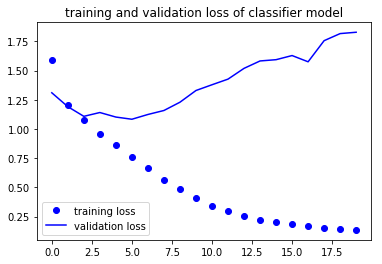

In [0]:
train_loss = classifier_history.history["loss"]
val_loss = classifier_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of classifier model")
plt.show()

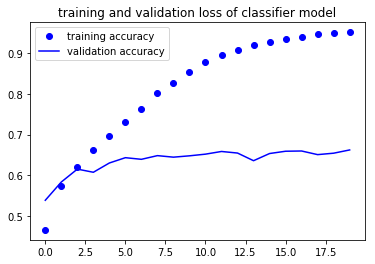

In [0]:
train_loss = classifier_history.history["acc"]
val_loss = classifier_history.history["val_acc"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training accuracy")
plt.plot(steps, val_loss, 'b',label = "validation accuracy")
plt.legend(loc="best")
plt.title("training and validation loss of classifier model")
plt.show()

the classifier is over-fitting, so we will introduce regularization by increasing the dropout rate and reducing the number of parameters of the model

#### 3- regularize the model

In [0]:
def cnn_model(encoded):
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(num_classes, activation="softmax")(x)
    return x
encoded = encoder_2(inputs)
classifier_2 = Model(inputs, cnn_model(encoded))
for clf_w, autoenc_w in zip(classifier_2.layers[:20], autoencoder_2.layers[:20]):
    clf_w.set_weights(autoenc_w.get_weights())
for l in classifier_2.layers[:20]:
    l.trainable = False
classifier_2.compile(optimizer = "adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier_2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_27 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 64)        1849

In [0]:
classifier_history = classifier_2.fit(x_tr, y_tr, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val))

Train on 34000 samples, validate on 8500 samples
Epoch 1/20
34000/34000 [==============================] - 20s 580us/step - loss: 0.5056 - acc: 0.8163 - val_loss: 1.0841 - val_acc: 0.6752
Epoch 2/20
34000/34000 [==============================] - 17s 488us/step - loss: 0.5076 - acc: 0.8183 - val_loss: 1.0603 - val_acc: 0.6798
Epoch 3/20
34000/34000 [==============================] - 16s 485us/step - loss: 0.5049 - acc: 0.8171 - val_loss: 1.1020 - val_acc: 0.6751
Epoch 4/20
34000/34000 [==============================] - 16s 484us/step - loss: 0.4948 - acc: 0.8226 - val_loss: 1.0655 - val_acc: 0.6845
Epoch 5/20
34000/34000 [==============================] - 17s 486us/step - loss: 0.4887 - acc: 0.8233 - val_loss: 1.0690 - val_acc: 0.6878
Epoch 6/20
34000/34000 [==============================] - 17s 485us/step - loss: 0.4829 - acc: 0.8260 - val_loss: 1.0757 - val_acc: 0.6825
Epoch 7/20
34000/34000 [==============================] - 16s 485us/step - loss: 0.4836 - acc: 0.8252 - val_loss: 1.0

#### 4- take a look at the prediction

Even after adding dropout layers and increasing the dropout rate, the model still over-fit.<br>
Let's see what are the classes that were difficult to predict

In [0]:
y_pred = classifier_2.predict(x_val)

In [0]:
print(classes)
confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


array([[652,  21,  13,  45,  22,  15,  21,  30, 141,  40],
       [ 23, 750,   0,  23,   7,   8,  18,  14,  59,  98],
       [ 30,   1, 149,  99,  46,  60,  62,  38,  10,   5],
       [ 11,   6,  20, 598,  37, 159, 108,  25,  20,  16],
       [  9,   0,  17,  43, 311,  27,  51,  30,  11,   1],
       [  6,   6,  10, 287,  47, 537,  51,  45,   7,   4],
       [  1,   4,   4,  70,  41,  30, 831,   5,   9,   5],
       [  4,   6,   3,  71,  79,  57,  18, 743,  10,   9],
       [ 39,  34,   1,  33,   8,  12,  11,   7, 830,  25],
       [  6,  64,   3,  23,   4,   6,  13,  14,  22, 345]])

we can see that the model has the following problems:
   - it confuses airplane and ships
   - it confuses dogs with cats

#### 5- unfroze some layers

In [0]:
# we will use the same model, but we will decrease the number of frosen layers from the autoencoder
encoded = encoder_2(inputs)
classifier_3 = Model(inputs, cnn_model(encoded))
for clf_w, autoenc_w in zip(classifier_3.layers[1:20], autoencoder_2.layers[1:20]):
    clf_w.set_weights(autoenc_w.get_weights())
for l in classifier_3.layers[1:5]:
    l.trainable = False
classifier_3.compile(optimizer = "adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier_3.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_38 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 64)        1849

In [0]:
classifier_history = classifier_3.fit(x_tr, y_tr, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val))

Train on 34000 samples, validate on 8500 samples
Epoch 1/20
34000/34000 [==============================] - 40s 1ms/step - loss: 1.0368 - acc: 0.6321 - val_loss: 0.9604 - val_acc: 0.6605
Epoch 2/20
34000/34000 [==============================] - 38s 1ms/step - loss: 0.9101 - acc: 0.6782 - val_loss: 0.9371 - val_acc: 0.6766
Epoch 3/20
34000/34000 [==============================] - 32s 942us/step - loss: 0.8198 - acc: 0.7116 - val_loss: 0.8849 - val_acc: 0.6960
Epoch 4/20
34000/34000 [==============================] - 31s 918us/step - loss: 0.7356 - acc: 0.7410 - val_loss: 0.8346 - val_acc: 0.7158
Epoch 5/20
34000/34000 [==============================] - 35s 1ms/step - loss: 0.6561 - acc: 0.7711 - val_loss: 0.8384 - val_acc: 0.7166
Epoch 6/20
34000/34000 [==============================] - 31s 913us/step - loss: 0.5875 - acc: 0.7935 - val_loss: 0.8193 - val_acc: 0.7302
Epoch 7/20
34000/34000 [==============================] - 35s 1ms/step - loss: 0.5268 - acc: 0.8181 - val_loss: 0.7202 - va

we tried freezing the first 15, 10 and 5 layers. The model still overfit.<br> 
Next we will combine the auto-encoder and the classifier in one model and train it end to end and we will change the structure of the autoencoder.


## Train end to end model

We will construct a model that takes as input an image, and that has to output an image and the class of the image. the output image is the label of the autoencoder and the class is the label of the classifier.<br>
To make training easier, faster and accurate, we will construct shallow models but with large filter number and we will use different kernel size(1-3-5).

At first we will create the autoencoders and train them in order to use their weights to initialize the calssifier weights.

#### encoder 4

In [0]:
#encoder
def encoder_4(inputs):
    x = layers.Conv2D(96, 5, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(96, 1, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(192, 5, activation="relu", padding="same")(x)
    x = layers.Conv2D(192, 1, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.5)(x)
    return x

#decoder
def decoder_4(encoded):
    x = layers.Conv2D(192, 5, activation="relu", padding="same")(encoded)
    x = layers.Conv2D(192, 1, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(3)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(96, 5, activation="relu")(x)
    x = layers.Conv2D(96, 1, activation="relu")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    decoded = layers.Conv2D(3, 1, activation="sigmoid", padding="same", name="autoencoder")(x)
    return decoded

autoencoder_4 = Model(inputs, decoder_4(encoder_4(inputs)))

In [0]:
autoencoder_4.compile(optimizer="adam", loss="mse")
autoencoder_4.summary()

W0902 10:05:57.172035 140360913360640 deprecation_wrapper.py:118] From /home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        7296      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        9312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 96)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 192)       460992    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 192)       37056     
__________

In [0]:
autoencoder_history = autoencoder_4.fit(x_tr, x_tr, batch_size=batch_size, epochs=100, validation_data=(x_val, x_val))

Train on 34000 samples, validate on 8500 samples
Epoch 1/100
34000/34000 [==============================] - 26s 768us/step - loss: 0.0205 - val_loss: 0.0121
Epoch 2/100
34000/34000 [==============================] - 22s 654us/step - loss: 0.0119 - val_loss: 0.0091
Epoch 3/100
34000/34000 [==============================] - 22s 647us/step - loss: 0.0106 - val_loss: 0.0078
Epoch 4/100
34000/34000 [==============================] - 22s 645us/step - loss: 0.0099 - val_loss: 0.0075
Epoch 5/100
34000/34000 [==============================] - 22s 648us/step - loss: 0.0095 - val_loss: 0.0070
Epoch 6/100
34000/34000 [==============================] - 22s 648us/step - loss: 0.0092 - val_loss: 0.0067
Epoch 7/100
34000/34000 [==============================] - 22s 650us/step - loss: 0.0090 - val_loss: 0.0070
Epoch 8/100
34000/34000 [==============================] - 22s 648us/step - loss: 0.0088 - val_loss: 0.0065
Epoch 9/100
34000/34000 [==============================] - 22s 647us/step - loss: 0.008

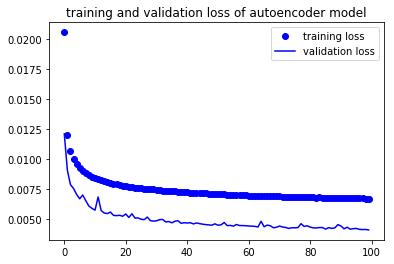

In [0]:
train_loss = autoencoder_history.history["loss"]
val_loss = autoencoder_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

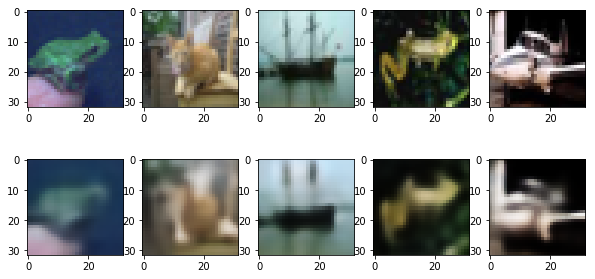

In [0]:
random_img = np.random.randint(0, len(x_val), 5)
fig, ax = plt.subplots(2, 5, figsize = (10,5))
for i, ind in enumerate(random_img):
    ax[0,i].imshow(x_val[ind])
    ax[1,i].imshow(autoencoder_4.predict(np.expand_dims(x_val[ind], 0)).reshape(32, 32, 3))

In [0]:
autoencoder_4 = models.load_model('autoencoder_4_model.h5')

#### encoder 5

In [0]:
#encoder
def encoder_5(inputs):
    x = layers.Conv2D(96, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(96, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.2)(x)
    return x

#decoder
def decoder_5(encoded):
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(encoded)
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(3)(x)
    
    
    x = layers.Conv2D(96, 3, activation="relu")(x)
    x = layers.Conv2D(96, 3, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    decoded = layers.Conv2D(3, 1, activation="sigmoid", padding="same",  name="autoencoder")(x)
    return decoded

autoencoder_5 = Model(inputs, decoder_5(encoder_5(inputs)))
autoencoder_5.compile(optimizer="adam", loss="mse")
autoencoder_5.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 96)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 192)       166080    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 192)       3319

In [0]:
model_check = ModelCheckpoint("autoencoder_5_model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)
autoencoder_history = autoencoder_5.fit(x_tr, x_tr, batch_size=batch_size, epochs=100, validation_data=(x_val, x_val), callbacks=[model_check])

Train on 34000 samples, validate on 8500 samples
Epoch 1/100
34000/34000 [==============================] - 28s 819us/step - loss: 0.0176 - val_loss: 0.0090
Epoch 2/100
34000/34000 [==============================] - 21s 619us/step - loss: 0.0086 - val_loss: 0.0066
Epoch 3/100
34000/34000 [==============================] - 21s 616us/step - loss: 0.0073 - val_loss: 0.0058
Epoch 4/100
34000/34000 [==============================] - 21s 613us/step - loss: 0.0066 - val_loss: 0.0053
Epoch 5/100
34000/34000 [==============================] - 21s 613us/step - loss: 0.0062 - val_loss: 0.0052
Epoch 6/100
34000/34000 [==============================] - 21s 615us/step - loss: 0.0059 - val_loss: 0.0046
Epoch 7/100
34000/34000 [==============================] - 21s 616us/step - loss: 0.0056 - val_loss: 0.0044
Epoch 8/100
34000/34000 [==============================] - 21s 614us/step - loss: 0.0054 - val_loss: 0.0049
Epoch 9/100
34000/34000 [==============================] - 21s 612us/step - loss: 0.005

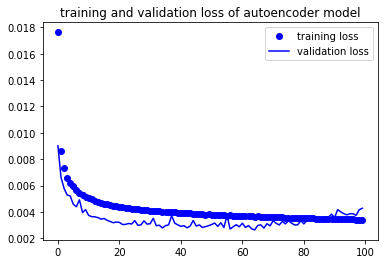

In [0]:
train_loss = autoencoder_history.history["loss"]
val_loss = autoencoder_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

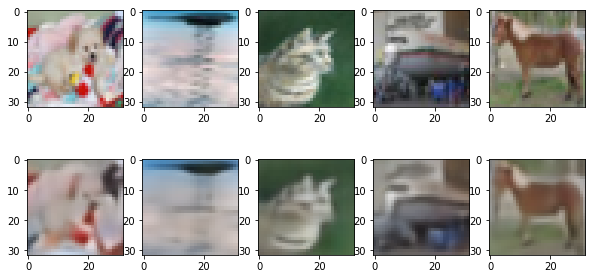

In [0]:
random_img = np.random.randint(0, len(x_val), 5)
fig, ax = plt.subplots(2, 5, figsize = (10,5))
for i, ind in enumerate(random_img):
    ax[0,i].imshow(x_val[ind])
    ax[1,i].imshow(autoencoder_5.predict(np.expand_dims(x_val[ind], 0)).reshape(32, 32, 3))

In [0]:
autoencoder_5=models.load_model('autoencoder_5_model.h5')

#### encoder 6

In [0]:
#encoder
def encoder_6(inputs):
    x = layers.Conv2D(96, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(96, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(96, 3, strides=2,activation="relu", padding="same")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(192, 3,activation="relu", padding="same")(x)
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(192, 3, strides=2,activation="relu", padding="same")(x)
    x = layers.Dropout(0.5)(x)
    return x

#decoder
def decoder_6(encoded):
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(encoded)
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(192, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(96, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(96, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(96, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Dropout(0.5)(x)
    
    decoded = layers.Conv2D(3, 3, activation="sigmoid", name="autoencoder", padding="same")(x)
    return decoded

autoencoder_6 = Model(inputs, decoder_6(encoder_6(inputs)))
autoencoder_6.compile(optimizer="adam", loss="mse")
autoencoder_6.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       166080    
_______

In [0]:
model_check = ModelCheckpoint("autoencoder_6_model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)
autoencoder_history = autoencoder_6.fit(x_tr, x_tr, batch_size=batch_size, epochs=20, validation_data=(x_val, x_val), callbacks=[model_check])


Train on 34000 samples, validate on 8500 samples
Epoch 1/20
34000/34000 [==============================] - 75s 2ms/step - loss: 0.0179 - val_loss: 0.0078
Epoch 2/20
34000/34000 [==============================] - 67s 2ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 3/20
34000/34000 [==============================] - 67s 2ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 4/20
34000/34000 [==============================] - 67s 2ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 5/20
34000/34000 [==============================] - 67s 2ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 6/20
34000/34000 [==============================] - 67s 2ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 7/20
34000/34000 [==============================] - 67s 2ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 8/20
34000/34000 [==============================] - 67s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/20
34000/34000 [==============================] - 67s 2ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch

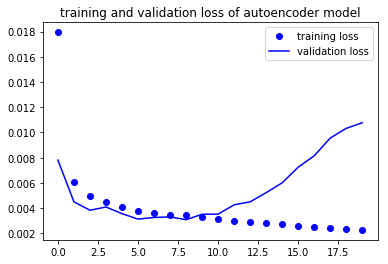

In [0]:
train_loss = autoencoder_history.history["loss"]
val_loss = autoencoder_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

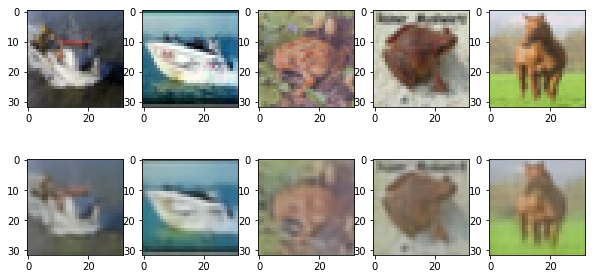

In [0]:
random_img = np.random.randint(0, len(x_val), 5)
fig, ax = plt.subplots(2, 5, figsize = (10,5))
for i, ind in enumerate(random_img):
    ax[0,i].imshow(x_val[ind])
    ax[1,i].imshow(autoencoder_6.predict(np.expand_dims(x_val[ind], 0)).reshape(32, 32, 3))

In [0]:
autoencoder_6=models.load_model('autoencoder_6_model.h5')

#### classifier

In [0]:
# create the CNN
decay = 1e-2
def cnn_model(encoded):
    x = layers.Conv2D(192, 3, activation="relu", padding="same", kernel_regularizer=l2(decay))(encoded)
    x = layers.Conv2D(192, 1, activation="relu", padding="same", kernel_regularizer=l2(decay))(x)
    x = layers.Conv2D(10, 1, activation="relu", padding="same", kernel_regularizer=l2(decay))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Activation("softmax", name="classifier_out")(x)
    return x

In [0]:
loss_funcs = {
        "autoencoder": "mse",
        "classifier_out": "categorical_crossentropy"
}
loss_weights = {"autoencoder": 1.0, "classifier_out": 2.0}
metrics = {
        "classifier_out": "accuracy",   
}
y_trains = {
        "autoencoder": x_tr,
        "classifier_out": y_tr}
y_valids = {
        "autoencoder": x_val,
        "classifier_out": y_val}

In [0]:
def lr_schedule(epoch):
    alpha = 0.01
    if epoch < 50:
        return alpha
    elif epoch < 100:
        return alpha*0.1
    elif epoch < 150:
        return alpha*0.01
    else:
        return alpha*0.001
lr_scheduler = LearningRateScheduler(lr_schedule)

#### with encoder 4

In [0]:
decay = 1e-2
encoded_4 = encoder_4(inputs)
classifier_6 = Model(inputs, [decoder_4(encoded_4), cnn_model(encoded_4)])
for clf_w, autoenc_w in zip(classifier_6.layers[:9], autoencoder_4.layers[:9]):
    clf_w.set_weights(autoenc_w.get_weights())
classifier_6.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 32, 32, 96)   7296        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 32, 96)   9312        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 15, 15, 96)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [0]:
model_check = ModelCheckpoint("classifier_6_model.h5", 
                              monitor='val_loss', 
                              verbose=0, 
                              save_best_only=True, 
                              save_weights_only=False)
classifier_6.compile(optimizer="sgd",loss=loss_funcs, loss_weights=loss_weights, metrics=metrics)

In [0]:
classifier_history = classifier_6.fit(x_tr, y_trains, 
                                      batch_size=batch_size, 
                                      epochs=200,
                                      validation_data=(x_val, y_valids),
                                      callbacks=[model_check, lr_scheduler])

W0903 10:14:57.064419 140175599744896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 34000 samples, validate on 8500 samples
Epoch 1/200
34000/34000 [==============================] - 29s 847us/step - loss: 7.8210 - autoencoder_loss: 0.0661 - classifier_out_loss: 2.0552 - classifier_out_acc: 0.2584 - val_loss: 7.0191 - val_autoencoder_loss: 0.0563 - val_classifier_out_loss: 1.8389 - val_classifier_out_acc: 0.3336
Epoch 2/200
34000/34000 [==============================] - 23s 675us/step - loss: 6.5840 - autoencoder_loss: 0.0530 - classifier_out_loss: 1.7761 - classifier_out_acc: 0.3575 - val_loss: 6.1641 - val_autoencoder_loss: 0.0365 - val_classifier_out_loss: 1.7175 - val_classifier_out_acc: 0.3828
Epoch 3/200
34000/34000 [==============================] - 23s 676us/step - loss: 5.7351 - autoencoder_loss: 0.0423 - classifier_out_loss: 1.6237 - classifier_out_acc: 0.4131 - val_loss: 5.9004 - val_autoencoder_loss: 0.0307 - val_classifier_out_loss: 1.8276 - val_classifier_out_acc: 0.3489
Epoch 4/200
34000/34000 [==============================] - 23s 680us/step -

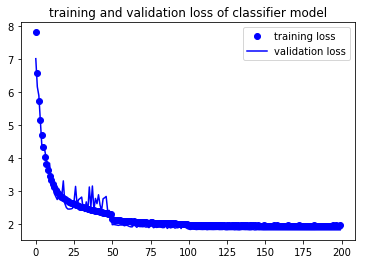

In [0]:
train_loss = classifier_history.history["loss"]
val_loss = classifier_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of classifier model")
plt.show()

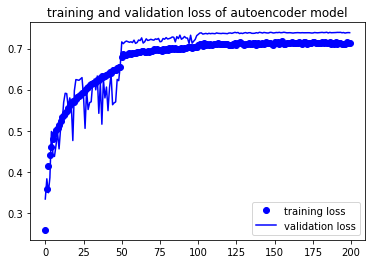

In [0]:
train_loss = classifier_history.history["classifier_out_acc"]
val_loss = classifier_history.history["val_classifier_out_acc"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

#### with encoder 5

In [0]:
decay = 1e-2
encoded_5 = encoder_5(inputs)
classifier_7 = Model(inputs, [decoder_5(encoded_5), cnn_model(encoded_5)])
for clf_w, autoenc_w in zip(classifier_7.layers[:9], autoencoder_5.layers[:9]):
    clf_w.set_weights(autoenc_w.get_weights())
classifier_7.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 32, 32, 96)   2688        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 32, 32, 96)   83040       conv2d_50[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 15, 15, 96)   0           conv2d_51[0][0]                  
____________________________________________________________________________________________

In [0]:
model_check = ModelCheckpoint("classifier_7_model.h5", 
                              monitor='val_loss', 
                              verbose=0, 
                              save_best_only=True, 
                              save_weights_only=False)
classifier_7.compile(optimizer="sgd",loss=loss_funcs, loss_weights=loss_weights, metrics=metrics)

In [0]:
classifier_history = classifier_7.fit(x_tr, y_trains, 
                                      batch_size=batch_size, 
                                      epochs=200,
                                      validation_data=(x_val, y_valids),
                                      callbacks=[model_check, lr_scheduler])

Train on 34000 samples, validate on 8500 samples
Epoch 1/200
34000/34000 [==============================] - 26s 760us/step - loss: 7.9725 - autoencoder_loss: 0.0567 - classifier_out_loss: 2.1366 - classifier_out_acc: 0.2166 - val_loss: 7.2835 - val_autoencoder_loss: 0.0422 - val_classifier_out_loss: 1.9804 - val_classifier_out_acc: 0.2778
Epoch 2/200
34000/34000 [==============================] - 22s 644us/step - loss: 6.5540 - autoencoder_loss: 0.0389 - classifier_out_loss: 1.7696 - classifier_out_acc: 0.3542 - val_loss: 6.0446 - val_autoencoder_loss: 0.0322 - val_classifier_out_loss: 1.6612 - val_classifier_out_acc: 0.3833
Epoch 3/200
34000/34000 [==============================] - 22s 640us/step - loss: 5.6228 - autoencoder_loss: 0.0336 - classifier_out_loss: 1.5714 - classifier_out_acc: 0.4291 - val_loss: 5.5683 - val_autoencoder_loss: 0.0286 - val_classifier_out_loss: 1.6610 - val_classifier_out_acc: 0.3987
Epoch 4/200
34000/34000 [==============================] - 22s 648us/step -

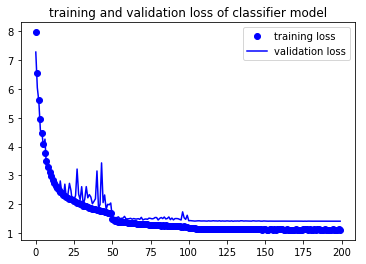

In [0]:
train_loss = classifier_history.history["loss"]
val_loss = classifier_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of classifier model")
plt.show()

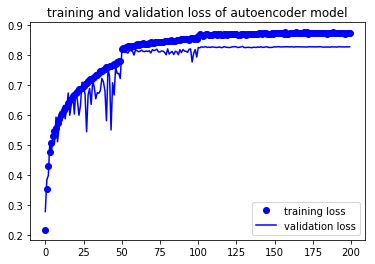

In [0]:
train_loss = classifier_history.history["classifier_out_acc"]
val_loss = classifier_history.history["val_classifier_out_acc"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

#### with encoder 6

In [0]:
decay=1e-2
encoded_6 = encoder_6(inputs)
classifier_8 = Model(inputs, [decoder_6(encoded_6), cnn_model(encoded_6)])
for clf_w, autoenc_w in zip(classifier_8.layers[:9], autoencoder_6.layers[:9]):
    clf_w.set_weights(autoenc_w.get_weights())
classifier_8.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 96)   2688        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 96)   83040       conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 16, 16, 96)   83040       conv2d_22[0][0]                  
____________________________________________________________________________________________

In [0]:
model_check = ModelCheckpoint("classifier_8_model.h5", 
                              monitor='val_loss', 
                              verbose=0, 
                              save_best_only=True, 
                              save_weights_only=False)
classifier_8.compile(optimizer="sgd",loss=loss_funcs, loss_weights=loss_weights, metrics=metrics)

In [0]:
classifier_history = classifier_8.fit(x_tr, y_trains, 
                                      batch_size=batch_size, 
                                      epochs=100, 
                                      validation_data=(x_val, y_valids),
                                      callbacks=[model_check, lr_scheduler])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 34000 samples, validate on 8500 samples
Epoch 1/100
34000/34000 [==============================] - 70s 2ms/step - loss: 8.1719 - autoencoder_loss: 0.0641 - classifier_out_loss: 2.2435 - classifier_out_acc: 0.1573 - val_loss: 7.6147 - val_autoencoder_loss: 0.0642 - val_classifier_out_loss: 2.1486 - val_classifier_out_acc: 0.2029
Epoch 2/100
34000/34000 [==============================] - 68s 2ms/step - loss: 7.0806 - autoencoder_loss: 0.0641 - classifier_out_loss: 2.0395 - classifier_out_acc: 0.2488 - val_loss: 6.6947 - val_autoencoder_loss: 0.0641 - val_classifier_out_loss: 1.9940 - val_classifier_out_acc: 0.2538
Epoch 3/100
34000/34000 [==============================] - 69s 2ms/step - loss: 6.2800 - autoencoder_loss: 0.0642 - classifier_out_loss: 1.9125 - classifier_out_acc: 0.3013 - val_loss: 5.9810 - val_autoencoder_loss: 0.0641 - val_classifier_out_loss: 1.8814 - val_classifier_out

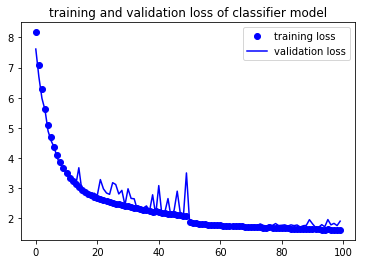

In [0]:
train_loss = classifier_history.history["loss"]
val_loss = classifier_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of classifier model")
plt.show()

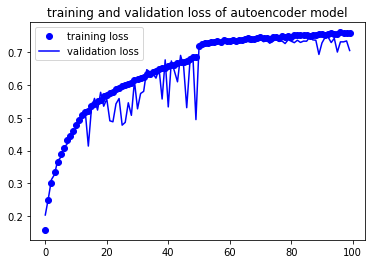

In [0]:
train_loss = classifier_history.history["classifier_out_acc"]
val_loss = classifier_history.history["val_classifier_out_acc"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

## data augentation

The best model is classifier_7 that uses autoencoder_5. We will try to optimize the hyperparameters of this model. but first let's see what are the categories that are difficult to predict   

In [0]:
# function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This function is from sklean website"""
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(13, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:
classifier_7 = models.load_model("classifier_7_model.h5")

W0905 12:56:11.094248 140295933306752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [0]:
_, y_pred = classifier_7.predict(x_val)
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(y_pred, axis=1)

Normalized confusion matrix
[[0.861 0.019 0.016 0.011 0.01  0.012 0.003 0.011 0.042 0.015]
 [0.01  0.923 0.002 0.003 0.    0.006 0.005 0.    0.016 0.035]
 [0.068 0.008 0.618 0.068 0.036 0.074 0.076 0.03  0.016 0.006]
 [0.021 0.003 0.024 0.685 0.022 0.132 0.059 0.029 0.016 0.009]
 [0.02  0.    0.032 0.048 0.74  0.03  0.052 0.066 0.012 0.   ]
 [0.006 0.002 0.013 0.127 0.027 0.76  0.022 0.034 0.004 0.005]
 [0.007 0.004 0.012 0.038 0.019 0.011 0.898 0.005 0.005 0.001]
 [0.009 0.002 0.011 0.029 0.017 0.03  0.005 0.891 0.002 0.004]
 [0.028 0.014 0.003 0.007 0.002 0.004 0.002 0.001 0.927 0.012]
 [0.036 0.058 0.002 0.024 0.002 0.004 0.008 0.014 0.02  0.832]]


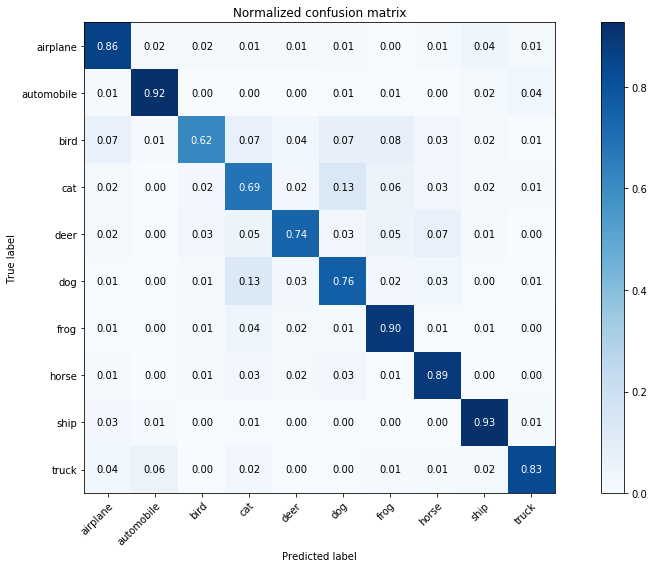

In [0]:
plot_confusion_matrix(y_true, y_pred, classes=np.array(classes), normalize=True,
                      title='Normalized confusion matrix')

we can see from the confusion matrix that the difficult categories are bird, cat, deer and dog.<br> For the dog and cat, they are difficult to classify because they have similar features. But for the bird and deer, the reason is because we only used half of the data.<br> So next we will try to improve classifier_7 by using data augmentation and optimizing the hyperparameters.

In [0]:
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True)

#generator that yield the class and the image as output
def data_generator(x_train, y_train, batch_size):
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
        yield (x_batch, {"autoencoder": x_batch, "classifier_out": y_batch})


In [0]:
decay = 1e-2
loss_weights = {"autoencoder": 1.0, "classifier_out": 2.0}
# learning rate scheduler
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 50:
        lrate = 0.0001
    if epoch > 75:
        lrate = 0.00005
    if epoch > 100:
        lrate = 0.00001
    return lrate

autoencoder_5 = models.load_model("autoencoder_5_model.h5")

lr_scheduler = LearningRateScheduler(lr_schedule)

# reduce LR by 0.2 if validation loss doesn't descrease after 5 iterations
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)
# optimizer
opt = rmsprop(0.001, decay=1e-6)

#encoder
def encoder_5(inputs):
    x = layers.Conv2D(96, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(96, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2)(x)
    x = layers.Dropout(0.5)(x)
    return x

#decoder
def decoder_5(encoded):
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(encoded)
    x = layers.Conv2D(192, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(3)(x)
    x = layers.Dropout(0.5)(x)

    
    x = layers.Conv2D(96, 3, activation="relu")(x)
    x = layers.Conv2D(96, 3, activation="relu")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Dropout(0.5)(x)
    decoded = layers.Conv2D(3, 3, activation="sigmoid",  name="autoencoder")(x)
    return decoded

# create the CNN
def cnn_model(encoded):
    x = layers.Conv2D(192, 3, activation="relu", padding="same", kernel_regularizer=l2(decay))(encoded)
    x = layers.Conv2D(192, 1, activation="relu", padding="same", kernel_regularizer=l2(decay))(x)
    x = layers.Conv2D(10, 1, activation="relu", padding="same", kernel_regularizer=l2(decay))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Activation("softmax", name="classifier_out")(x)
    return x

encoded_5 = encoder_5(inputs)
classifier_9 = Model(inputs, [decoder_5(encoded_5), cnn_model(encoded_5)])

# save the best model
model_check = ModelCheckpoint("classifier_9.h5", 
                              monitor='val_loss', 
                              verbose=0, 
                              save_best_only=True, 
                              save_weights_only=False)
for clf_w, autoenc_w in zip(classifier_9.layers[:9], autoencoder_5.layers[:9]):
    clf_w.set_weights(autoenc_w.get_weights())
classifier_9.compile(optimizer=opt,loss=loss_funcs, loss_weights=loss_weights, metrics=metrics)

In [0]:
classifier_history = classifier_9.fit_generator(data_generator(x_tr, y_tr, batch_size),
                        steps_per_epoch = len(x_tr)/batch_size,     
                        epochs=125,
                        validation_data = (x_val, y_valids),
                        callbacks=[model_check, reduce_lr, lr_scheduler])

Epoch 1/125
532/531 [==============================] - 60s 113ms/step - loss: 4.1063 - autoencoder_loss: 0.0234 - classifier_out_loss: 1.8423 - classifier_out_acc: 0.3212 - val_loss: 3.3030 - val_autoencoder_loss: 0.0158 - val_classifier_out_loss: 1.5305 - val_classifier_out_acc: 0.4538
Epoch 2/125
532/531 [==============================] - 58s 108ms/step - loss: 3.3536 - autoencoder_loss: 0.0172 - classifier_out_loss: 1.5622 - classifier_out_acc: 0.4357 - val_loss: 2.7734 - val_autoencoder_loss: 0.0243 - val_classifier_out_loss: 1.2710 - val_classifier_out_acc: 0.5468
Epoch 3/125
532/531 [==============================] - 58s 108ms/step - loss: 3.0731 - autoencoder_loss: 0.0168 - classifier_out_loss: 1.4281 - classifier_out_acc: 0.4905 - val_loss: 2.8462 - val_autoencoder_loss: 0.0170 - val_classifier_out_loss: 1.3152 - val_classifier_out_acc: 0.5376
Epoch 4/125
532/531 [==============================] - 58s 108ms/step - loss: 2.8867 - autoencoder_loss: 0.0166 - classifier_out_loss: 1

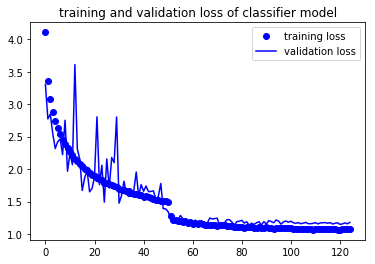

In [0]:
train_loss = classifier_history.history["loss"]
val_loss = classifier_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of classifier model")
plt.show()

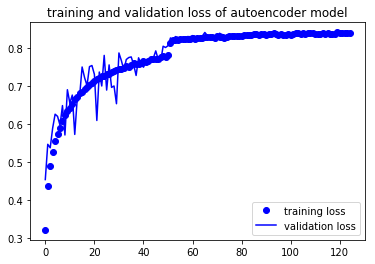

In [0]:
train_loss = classifier_history.history["classifier_out_acc"]
val_loss = classifier_history.history["val_classifier_out_acc"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

In [0]:
_, y_pred = classifier_9.predict(x_val)
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(y_pred, axis=1)

Normalized confusion matrix
[[0.871 0.017 0.013 0.001 0.006 0.003 0.016 0.011 0.04  0.022]
 [0.007 0.946 0.    0.    0.    0.    0.01  0.    0.005 0.032]
 [0.058 0.014 0.576 0.02  0.054 0.044 0.172 0.044 0.01  0.008]
 [0.021 0.006 0.018 0.632 0.023 0.078 0.148 0.038 0.012 0.024]
 [0.014 0.    0.02  0.018 0.73  0.014 0.124 0.066 0.01  0.004]
 [0.004 0.004 0.012 0.075 0.035 0.752 0.069 0.032 0.003 0.014]
 [0.008 0.002 0.004 0.006 0.003 0.002 0.968 0.002 0.002 0.003]
 [0.006 0.003 0.003 0.014 0.016 0.014 0.02  0.912 0.004 0.008]
 [0.032 0.015 0.002 0.003 0.001 0.    0.005 0.001 0.921 0.02 ]
 [0.018 0.044 0.    0.002 0.004 0.    0.004 0.006 0.002 0.92 ]]


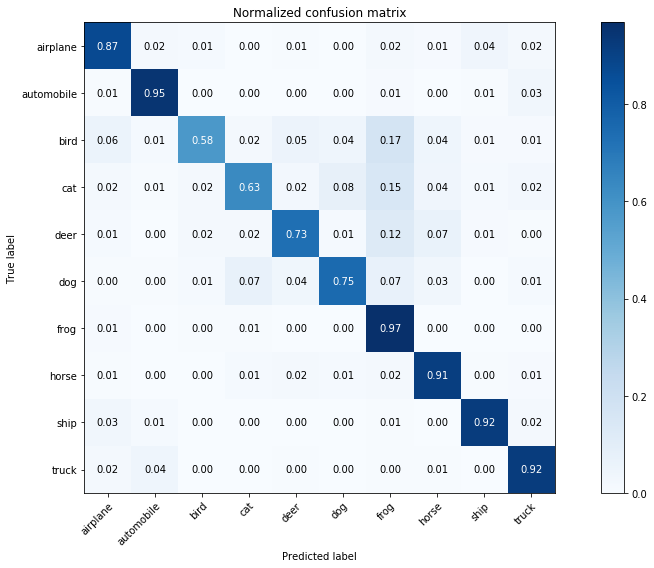

In [0]:
plot_confusion_matrix(y_true, y_pred, classes=np.array(classes), normalize=True,
                      title='Normalized confusion matrix')

The accuracy improved but the model still find it difficult to detect the bird, deer, cat and dog class.<br>
The solve this problem, will balance the data by creating a new image for each image from the bird, deer and truck class. We will create the new images by applying a random rotation, shift and horizontal flip.

### Balance the Data

In [0]:
# transformation functions
def random_rotation(image):
    random_degree = np.random.uniform(-10, 10)
    return transform.rotate(image, random_degree)

def random_shift(image):
    h_shift = np.random.uniform(-4, 4)
    w_shift = np.random.uniform(-4, 4)
    return shift(image, [h_shift, w_shift, 0])

def horizontal_flip(image):
    return np.fliplr(image)

In [38]:
# previous data with missing values
x_ptrain.shape, y_ptrain.shape

((42500, 32, 32, 3), (42500, 1))

In [39]:
# the images and labels from the bird, deer and truck class 
x_lost = x_ptrain[np.isin(y_ptrain.T[0], [2, 4, 9])]
y_lost = y_ptrain[np.isin(y_ptrain.T[0], [2, 4, 9])]
x_lost.shape, y_lost.shape

((7500, 32, 32, 3), (7500, 1))

In [0]:
# we will apply a number of transformation  based on a random value
x_add, y_add = [], []
for img, lab in zip(x_lost, y_lost):
  random_choice = np.random.uniform(size = 3)
  transformed_image = img
  if random_choice[0]>0.5:
    transformed_image = random_rotation(transformed_image)
  if random_choice[1]>0.5:
    transformed_image = random_shift(transformed_image)
  if random_choice[2]>0.5:
    transformed_image = horizontal_flip(transformed_image)
  x_add.append(transformed_image)
  y_add.append(lab)  

In [0]:
x_add = np.stack(x_add, axis=0)
y_add = np.array(y_add).reshape(-1, 1)

In [0]:
# create the balanced data set
x_train_complet = np.concatenate([x_ptrain, x_add])
y_train_complet = np.concatenate([y_ptrain, y_add])

In [43]:
# number of images from each class
pd.value_counts(pd.Series(y_train_complet.reshape(len(x_train_complet)))).sort_index()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64

In [0]:
y_cat_complet =keras.utils.to_categorical(y_train_complet, num_classes=num_classes)
x_tr, x_val, y_tr, y_val = train_test_split(x_train_complet, y_cat_complet,test_size = 0.2, random_state=123, stratify=y_train_complet)

In [0]:
y_trains = {
        "autoencoder": x_tr,
        "classifier_out": y_tr}
y_valids = {
        "autoencoder": x_val,
        "classifier_out": y_val}

In [0]:
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True)

#generator that yield the class and the image as output
def data_generator(x_train, y_train, batch_size):
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
        yield (x_batch, {"autoencoder": x_batch, "classifier_out": y_batch})

In [48]:
model_check = ModelCheckpoint("classifier_9_balanced_data.h5", 
                              monitor='val_loss', 
                              verbose=0, 
                              save_best_only=True, 
                              save_weights_only=False)
classifier_history = classifier_9.fit_generator(data_generator(x_tr, y_tr, batch_size),
                        steps_per_epoch = len(x_tr)/batch_size,     
                        epochs=125,
                        validation_data = (x_val, y_valids),
                        callbacks=[model_check, reduce_lr, lr_scheduler])

Epoch 1/125
625/625 [==============================] - 66s 105ms/step - loss: 1.5652 - autoencoder_loss: 0.0191 - classifier_out_loss: 0.7150 - classifier_out_acc: 0.7635 - val_loss: 1.2039 - val_autoencoder_loss: 0.0194 - val_classifier_out_loss: 0.5305 - val_classifier_out_acc: 0.8329
Epoch 2/125
625/625 [==============================] - 64s 102ms/step - loss: 1.5208 - autoencoder_loss: 0.0193 - classifier_out_loss: 0.6870 - classifier_out_acc: 0.7743 - val_loss: 1.1406 - val_autoencoder_loss: 0.0196 - val_classifier_out_loss: 0.4963 - val_classifier_out_acc: 0.8408
Epoch 3/125
625/625 [==============================] - 64s 102ms/step - loss: 1.5226 - autoencoder_loss: 0.0194 - classifier_out_loss: 0.6864 - classifier_out_acc: 0.7745 - val_loss: 1.3232 - val_autoencoder_loss: 0.0196 - val_classifier_out_loss: 0.5863 - val_classifier_out_acc: 0.8064
Epoch 4/125
625/625 [==============================] - 64s 102ms/step - loss: 1.5052 - autoencoder_loss: 0.0194 - classifier_out_loss: 0

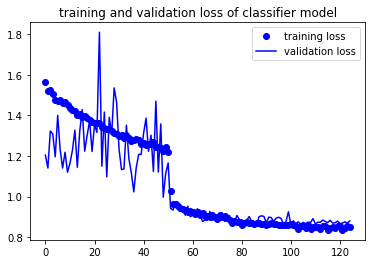

In [50]:
train_loss = classifier_history.history["loss"]
val_loss = classifier_history.history["val_loss"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of classifier model")
plt.show()

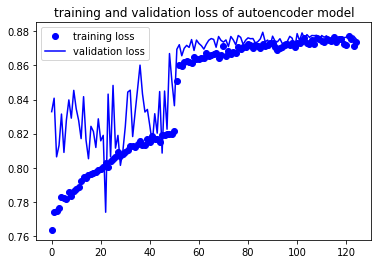

In [51]:
train_loss = classifier_history.history["classifier_out_acc"]
val_loss = classifier_history.history["val_classifier_out_acc"]
steps = range(len(train_loss))
plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

In [0]:
_, y_pred = classifier_9.predict(x_val)
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(y_pred, axis=1)

Normalized confusion matrix
[[0.874 0.007 0.026 0.002 0.006 0.007 0.014 0.021 0.018 0.025]
 [0.006 0.917 0.003 0.003 0.    0.002 0.007 0.    0.007 0.055]
 [0.024 0.001 0.837 0.003 0.016 0.047 0.056 0.01  0.001 0.005]
 [0.015 0.004 0.026 0.605 0.015 0.163 0.112 0.029 0.011 0.02 ]
 [0.011 0.    0.052 0.006 0.812 0.019 0.05  0.046 0.    0.004]
 [0.004 0.001 0.009 0.044 0.012 0.841 0.045 0.036 0.004 0.004]
 [0.004 0.001 0.016 0.008 0.005 0.008 0.95  0.003 0.    0.005]
 [0.01  0.    0.005 0.012 0.008 0.052 0.009 0.894 0.003 0.007]
 [0.057 0.02  0.007 0.001 0.001 0.001 0.006 0.005 0.871 0.031]
 [0.004 0.01  0.003 0.001 0.002 0.002 0.005 0.005 0.002 0.966]]


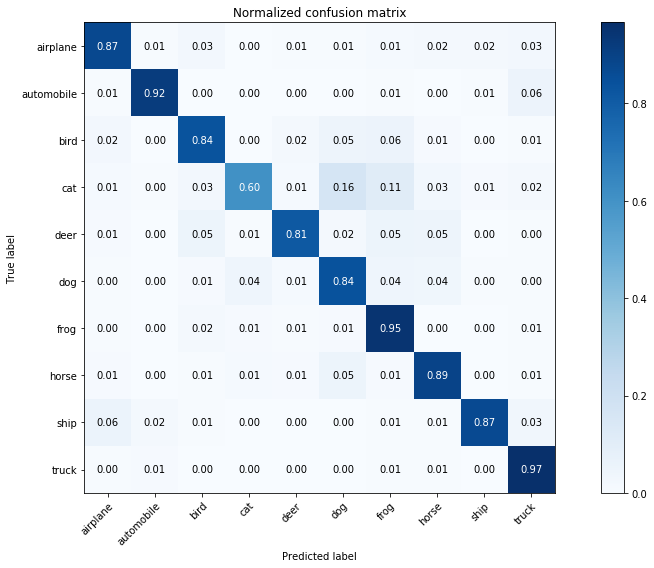

In [55]:
plot_confusion_matrix(y_true, y_pred, classes=np.array(classes), normalize=True,
                      title='Normalized confusion matrix')

We can see that the accuracy improved very much and that the bird, deer and dog class have high accuracy now.

## Testing

Before using our final model to predict testing data labels, we will train it on whole training data + validation data.<br>
in the previous model, the accuracy stagnate at epoch 100.
So we will train the model for only 100 epochs instead of 125.

In [0]:
model_check = ModelCheckpoint("final_model.h5", 
                              monitor='classifier_out_acc', 
                              verbose=0, 
                              save_best_only=True, 
                              save_weights_only=False)

In [0]:
final_model = classifier_9

In [71]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 25:
        lrate = 0.0001
    if epoch > 50:
        lrate = 0.00001
    if epoch > 75:
        lrate = 0.000001
    return lrate
lr_scheduler = LearningRateScheduler(lr_schedule)
classifier_history = final_model.fit_generator(data_generator(x_train_complet, y_cat_complet, batch_size),
                        steps_per_epoch = len(x_ptrain)/batch_size,     
                        epochs=100,
                        callbacks=[model_check, lr_scheduler])

Epoch 1/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2186 - autoencoder_loss: 0.0210 - classifier_out_loss: 0.5455 - classifier_out_acc: 0.8224
Epoch 2/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2163 - autoencoder_loss: 0.0209 - classifier_out_loss: 0.5440 - classifier_out_acc: 0.8249
Epoch 3/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2169 - autoencoder_loss: 0.0210 - classifier_out_loss: 0.5442 - classifier_out_acc: 0.8231
Epoch 4/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2039 - autoencoder_loss: 0.0210 - classifier_out_loss: 0.5375 - classifier_out_acc: 0.8228
Epoch 5/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2112 - autoencoder_loss: 0.0209 - classifier_out_loss: 0.5417 - classifier_out_acc: 0.8220
Epoch 6/100
665/664 [==============================] - 65s 97ms/step - loss: 1.2078 - autoencoder_loss: 0.0209 - classifier_out_loss: 0.5399 - classif

In [79]:
#y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
y_tests = {
        "autoencoder": x_test,
        "classifier_out": y_test}
score = final_model.evaluate(x_test, y_tests)
print("test accuracy : {0:.2f}".format(score[3]*100))

10000/10000 [==============================] - 6s 567us/step
test accuracy : 85.41


Normalized confusion matrix
[[0.936 0.009 0.009 0.001 0.003 0.001 0.009 0.006 0.017 0.009]
 [0.001 0.988 0.    0.    0.    0.    0.004 0.    0.002 0.005]
 [0.018 0.001 0.888 0.003 0.014 0.011 0.044 0.013 0.003 0.005]
 [0.011 0.009 0.009 0.763 0.021 0.067 0.078 0.027 0.01  0.005]
 [0.005 0.    0.011 0.003 0.911 0.007 0.042 0.02  0.    0.001]
 [0.004 0.003 0.007 0.044 0.012 0.844 0.046 0.034 0.004 0.002]
 [0.006 0.    0.004 0.003 0.002 0.001 0.982 0.001 0.001 0.   ]
 [0.005 0.001 0.003 0.01  0.006 0.02  0.011 0.939 0.003 0.002]
 [0.016 0.01  0.002 0.001 0.001 0.    0.002 0.002 0.961 0.005]
 [0.005 0.02  0.002 0.    0.    0.    0.004 0.001 0.002 0.966]]


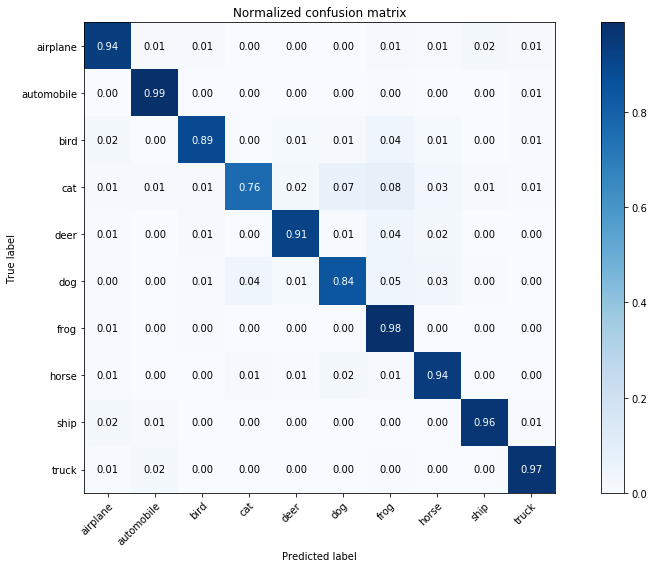

In [80]:
_, y_pred = classifier_9.predict(x_val)
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_true, y_pred, classes=np.array(classes), normalize=True,
                      title='Normalized confusion matrix')